In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline

In [2]:
class ConvCaps2D(nn.Module):
    def __init__(self):
        super(ConvCaps2D, self).__init__()
        # The paper suggests having 32 8D capsules
        self.capsules = nn.ModuleList([nn.Conv2d(in_channels = 100, out_channels = 8, kernel_size=(1,4), stride=2)
                                       for _ in range(32)])
        
    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm) # scale.size()  is (None, 1152, 1)  
        return scale*tensor / torch.sqrt(norm)
        
    def forward(self, x):
        outputs = [capsule(x).view(x.size(0), 8, -1) for capsule in self.capsules] # 32 list of (None, 1, 8, 36)
        outputs = torch.cat(outputs, dim = 2).permute(0, 2, 1)  # outputs.size() is (None, 1152, 8)
        return self.squash(outputs)

In [3]:
class Caps1D(nn.Module):
    def __init__(self):
        super(Caps1D, self).__init__()
        self.num_caps = 11
        self.num_iterations = 3
        self.W = nn.Parameter(torch.randn(11, 928, 8, 16))
        
    def softmax(self, x, dim = 1):
        transposed_input = x.transpose(dim, len(x.size()) - 1)
        softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)))
        return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(x.size()) - 1)

    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm)        
        return scale*tensor / torch.sqrt(norm)
   
    # Routing algorithm
    def forward(self, u):
        # u.size() is (None, 1152, 8)
        '''
        From documentation
        For example, if tensor1 is a j x 1 x n x m Tensor and tensor2 is a k x m x p Tensor, 
        out will be an j x k x n x p Tensor.
        
        We need j = None, 1, n = 1152, k = 10, m = 8, p = 16
        '''
        
        u_ji = torch.matmul(u[:, None, :, None, :], self.W) # u_ji.size() is (None, 10, 1152, 1, 16)
        
        b = Variable(torch.zeros(u_ji.size())) # b.size() is (None, 10, 1152, 1, 16)
        
        for i in range(self.num_iterations):
            c = self.softmax(b, dim=2)
            v = self.squash((c * u_ji).sum(dim=2, keepdim=True)) # v.size() is (None, 10, 1, 1, 16)

            if i != self.num_iterations - 1:
                delta_b = (u_ji * v).sum(dim=-1, keepdim=True)
                b = b + delta_b
        
        # Now we simply compute the length of the vectors and take the softmax to get probability.
        v = v.squeeze()
        classes = (v ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes) # This is not done in the paper, but I've done this to use CrossEntropyLoss.
        
        return classes
net = Caps1D()


In [4]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 100, kernel_size = (1,4), stride = 1)
        
        self.primaryCaps = ConvCaps2D()
        self.digitCaps = Caps1D()
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        
        return x

net = CapsNet()

In [5]:
def evaluate(model, X, Y, batch_size = 200):
    results = []
    predicted = []
    for i in range(len(X)//batch_size):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        
        predicted += list(np.argmax(pred.data.cpu().numpy(), axis = 1))

    Y=Y[0:len(predicted)]
    acc = sum(Y == predicted)*1.0/(len(Y))  
    return acc

In [6]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
data=pd.read_csv('rna_meth_liger.csv',index_col=0)
label=np.genfromtxt('rna_meth_liger_cell.csv',delimiter=',').astype('int64')

In [8]:
data.shape

(3111, 64)

In [9]:
label.shape

(3111,)

In [10]:
batch_size=200
trn_acc = []
tst_acc = []
trn_loss =[]
tst_loss=[]
#net=CapsNet()
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

d=X_train.values.reshape(len(X_train),1, 64, order='F')
d1_train=np.expand_dims(d.astype('float32'), 1)
        #l1_train=y_train
indices = np.random.permutation(len(d1_train))
d1_train=d1_train[indices]
l1_train=y_train[indices]

d1=X_val.values.reshape(len(X_val),1, 64, order='F')
d1_test=np.expand_dims(d1.astype('float32'), 1)
      # l1_test=y_test
indices = np.random.permutation(len(d1_test))
d1_test=d1_test[indices]
l1_test=y_val[indices]
#liveloss = PlotLosses()


logs = {}
loss_trn=[]
loss_test=[]
    #net1=net

for epoch in range(200):  # 500 epochs
    for phase in ['train', 'validation']:
        if phase == 'train':
            running_loss=0 
            for i in range(len(d1_train)//batch_size-1):    ##iteration
                print(i,)
                s = i*batch_size
                e = i*batch_size+batch_size

                inputs = torch.from_numpy(d1_train[s:e])
                labels = torch.LongTensor(np.array(l1_train[s:e]))

                    # wrap them in Variable
                inputs, labels = Variable(inputs), Variable(labels)

                    # zero the parameter gradients
                optimizer.zero_grad()

                    # forward + backward + optimize
                outputs = net(inputs)

                loss = criterion(outputs, labels)
                loss.backward()

                optimizer.step()
                running_loss += loss.data.item()
        #    print("Epoch, Loss - {}, {}".format(i, running_loss))
                del inputs, labels
                #print('\n')
               # trn_loss.append(running_loss)
        else: 
            r=random.sample(range(1, len(d1_train)), 1000)
            trn_acc.append(evaluate(net, d1_train[r], l1_train[r], batch_size = 200)) 
            tst_acc.append(evaluate(net, d1_test, l1_test, batch_size=200)) 
            out_train=net(torch.from_numpy(d1_train[r]))
            out_test=net(torch.from_numpy(d1_test))
            loss_trn = criterion(out_train, torch.LongTensor(np.array(l1_train[r])))
            loss_test= criterion(out_test, torch.LongTensor(np.array(l1_test)))
            trn_loss.append(loss_trn.data.item())
            tst_loss.append(loss_test.data.item())
            print("train_acc",trn_acc)
            print("test_acc",tst_acc)
            print("train_loss",trn_loss)
            print("test_acc",tst_loss)
           # logs['log_loss_trn'] = loss_trn.append(loss_trn)
           # logs['log_loss_tst'] = loss_test.append(loss_test)
          #  logs['tr_accuracy'] = trn_acc[-1]
          #  logs['tst_accuracy'] = tst_acc[-1]

   # liveloss.update(logs)
    #liveloss.draw()
    #print("Epoch, Loss - {}, {}".format(epoch, running_loss))
    #print("Train - ", trn_acc[-1])
    #print("Test - ", tst_acc[-1])

0


/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1
2
3
4
5
6
7
8
9
train_acc [0.234]
test_acc [0.24]
train_loss [2.3952980041503906]
test_acc [2.395174026489258]
0
1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263]
test_acc [0.24, 0.24]
train_loss [2.3952980041503906, 2.3829846382141113]
test_acc [2.395174026489258, 2.383898973464966]
0
1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253]
test_acc [0.24, 0.24, 0.24]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086]
test_acc [2.395174026489258, 2.383898973464966, 2.373871326446533]
0
1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277]
test_acc [0.24, 0.24, 0.24, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082]
test_acc [2.395174026489258, 2.383898973464966, 2.373871326446533, 2.367748975753784]
0
1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082, 2.3641836643218994]
test_acc

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082, 2.3641836643218994, 2.360487461090088, 2.360476016998291, 2.3595595359802246, 2.3598344326019287, 2.3614141941070557, 2.3574860095977783, 2.359391212463379, 2.3615005016326904, 2.3596763610839844, 2.357851028442383, 2.3585779666900635, 2.3576879501342773]
test_acc [2.395174026489258, 2.383898973464966, 2.373871326446533, 2.367748975753784, 2.3640360832214355, 2.3620450496673584, 2.360992908477783, 2.360366106033325, 2.3599722385406494, 2.359694004058838, 2.3594977855682373, 2.359326124191284, 2.359205961227417, 2.359093189239502, 2.3590078353881836, 2.3589413166046143, 2.3588709831237793]
0
1
2
3
4
5
6
7
8
9
train_

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082, 2.3641836643218994, 2.360487461090088, 2.360476016998291, 2.3595595359802246, 2.3598344326019287, 2.3614141941070557, 2.3574860095977783, 2.359391212463379, 2.3615005016326904, 2.3596763610839844, 2.357851028442383, 2.3585779666900635, 2.3576879501342773, 2.358961343765259, 2.359295606613159, 2.357050895690918, 2.36110782623291, 2.359670639038086, 2.357025623321533, 2.3575401306152344, 2.357912302017212]
test_acc [2.395174026489258, 2.383898973464966, 2.373871326446533, 2.367748975753784, 2.3640360

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082, 2.3641836643218994, 2.360487461090088, 2.360476016998291, 2.3595595359802246, 2.3598344326019287, 2.3614141941070557, 2.3574860095977783, 2.359391212463379, 2.3615005016326904, 2.3596763610839844, 2.357851028442383, 2.3585779666900635, 2.3576879501342773, 2.358961343765259, 2.359295606613159, 2.357050895690918, 2.36110782623291, 2.359670639038086, 2.357025623321533, 2.3575401306152344, 2.357912302017212, 2.358

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082, 2.3641836643218994, 2.360487461090088, 2.360476016998291, 2.3595595359802246, 2.3598344326019287, 2.3614141941070557, 2.3574860095977783, 2.359391212463379, 2.3615005016326904, 2.3596763610839844, 2.357851028442383, 2.3585779666900635, 2.3576879501342773, 2.358961343765259, 2.359295606613159, 2.357050895690918, 2.36110782623291, 2.35967063

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082, 2.3641836643218994, 2.360487461090088, 2.360476016998291, 2.3595595359802246, 2.3598344326019287, 2.3614141941070557, 2.3574860095977783, 2.359391212463379, 2.3615005016326904, 2.3596763610839844, 2.357851028442383, 2.3585779666900635, 2.3576879501342773, 2.358961343765259, 2.3592

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082, 2.3641836643218994, 2.360487461090088, 2.360476016998291, 2.3595595359802246, 2.3598344326019287, 2.3614141941070557, 2.3574860095977783, 2.359391212463379, 2.3615005016326904, 2.3596763610839844, 2.357851028442383, 2.358

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082, 2.3641836643218994, 2.360487461090088, 2.360476016998291, 2.3595595359802246, 2.3598344326019287, 2.3614141941070557, 2.3574860095977783, 2.359391212463379, 2.36

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082, 2.3641836643218994, 2.360487461090088, 2.360476016998291, 2.3595595359802246, 2.3598344326019287, 2.3

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082, 2.3641836643218994, 2.360487461090088, 2.360476016998291

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.3735647201538086, 2.367802619934082, 2.364183664

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875]
train_loss [2.3952980041503906, 2.3829846382141113, 2.373

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.25, 0.225, 0.2875]
train_loss [2.39

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.25, 0.225, 0.2

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.287

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.28

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875,

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.287

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875,

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.28

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.28

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.287

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875,

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.287

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875,

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.287

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875, 0.2875,

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2875, 0.2875, 0

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902]
test_acc [0.24, 0.24, 0.24, 0.2875, 0.2875, 0.2

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889]
test_acc [0.24, 0.24, 0.24, 0.287

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891]
test_acc [0.24, 0.2

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885]
test_

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

1
2
3
4
5
6
7
8
9
train_acc [0.234, 0.263, 0.253, 0.277, 0.278, 0.297, 0.285, 0.293, 0.291, 0.269, 0.296, 0.284, 0.267, 0.269, 0.307, 0.28, 0.306, 0.271, 0.281, 0.286, 0.269, 0.278, 0.29, 0.294, 0.288, 0.278, 0.289, 0.268, 0.289, 0.303, 0.287, 0.273, 0.293, 0.29, 0.276, 0.3, 0.283, 0.287, 0.294, 0.281, 0.294, 0.281, 0.304, 0.281, 0.282, 0.292, 0.279, 0.298, 0.292, 0.292, 0.265, 0.261, 0.291, 0.282, 0.278, 0.298, 0.273, 0.285, 0.276, 0.295, 0.282, 0.246, 0.217, 0.29, 0.306, 0.301, 0.292, 0.281, 0.263, 0.301, 0.276, 0.262, 0.295, 0.283, 0.292, 0.294, 0.278, 0.284, 0.301, 0.283, 0.299, 0.3, 0.29, 0.289, 0.29, 0.301, 0.298, 0.283, 0.297, 0.311, 0.308, 0.293, 0.296, 0.309, 0.33, 0.336, 0.329, 0.362, 0.369, 0.361, 0.376, 0.349, 0.338, 0.336, 0.393, 0.409, 0.363, 0.341, 0.39, 0.397, 0.413, 0.4, 0.407, 0.431, 0.439, 0.449, 0.433, 0.447, 0.453, 0.457, 0.459, 0.489, 0.481, 0.502, 0.511, 0.514, 0.542, 0.583, 0.615, 0.677, 0.771, 0.891, 0.909, 0.902, 0.901, 0.889, 0.896, 0.891, 0.893, 0.885, 0.887

In [11]:
trn_acc[0:150]


[0.234,
 0.263,
 0.253,
 0.277,
 0.278,
 0.297,
 0.285,
 0.293,
 0.291,
 0.269,
 0.296,
 0.284,
 0.267,
 0.269,
 0.307,
 0.28,
 0.306,
 0.271,
 0.281,
 0.286,
 0.269,
 0.278,
 0.29,
 0.294,
 0.288,
 0.278,
 0.289,
 0.268,
 0.289,
 0.303,
 0.287,
 0.273,
 0.293,
 0.29,
 0.276,
 0.3,
 0.283,
 0.287,
 0.294,
 0.281,
 0.294,
 0.281,
 0.304,
 0.281,
 0.282,
 0.292,
 0.279,
 0.298,
 0.292,
 0.292,
 0.265,
 0.261,
 0.291,
 0.282,
 0.278,
 0.298,
 0.273,
 0.285,
 0.276,
 0.295,
 0.282,
 0.246,
 0.217,
 0.29,
 0.306,
 0.301,
 0.292,
 0.281,
 0.263,
 0.301,
 0.276,
 0.262,
 0.295,
 0.283,
 0.292,
 0.294,
 0.278,
 0.284,
 0.301,
 0.283,
 0.299,
 0.3,
 0.29,
 0.289,
 0.29,
 0.301,
 0.298,
 0.283,
 0.297,
 0.311,
 0.308,
 0.293,
 0.296,
 0.309,
 0.33,
 0.336,
 0.329,
 0.362,
 0.369,
 0.361,
 0.376,
 0.349,
 0.338,
 0.336,
 0.393,
 0.409,
 0.363,
 0.341,
 0.39,
 0.397,
 0.413,
 0.4,
 0.407,
 0.431,
 0.439,
 0.449,
 0.433,
 0.447,
 0.453,
 0.457,
 0.459,
 0.489,
 0.481,
 0.502,
 0.511,
 0.514,
 0.542

Text(0.5, 1.0, 'accuracy')

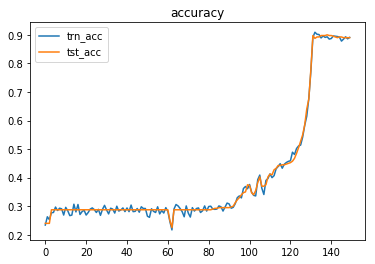

In [12]:
fig, ax = plt.subplots()
ax.plot(range(0,150), trn_acc[0:150], label = 'trn_acc')
ax.plot(range(0,150), tst_acc[0:150], label = 'tst_acc')
leg = ax.legend()
plt.title('accuracy')

In [13]:
d=X_test.values.reshape(len(X_test),1, 64, order='F')
d1_test=np.expand_dims(d.astype('float32'), 1)
pred=net(Variable(torch.from_numpy(d1_test)))

/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [14]:
predicted=list(np.argmax(pred.data.cpu().numpy(), axis = 1))

In [15]:
from numpy import savetxt
savetxt('test_datarnameth.csv', X_test, delimiter=',')
savetxt('test_data_predlabel_rnameth.csv', predicted, delimiter=',')
savetxt('test_data_orglabel_rnameth.csv', y_test, delimiter=',')

In [9]:
from numpy import savetxt
savetxt('capsule_rnameth_trnacc.csv', trn_acc, delimiter=',')
savetxt('capsule_rnameth_tstacc.csv', tst_acc, delimiter=',')